In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
classification_report, accuracy_score, confusion_matrix, roc_curve, auc
)
#Load dataset
data = pd.read_csv('/content/campaign_responses.csv')
data.head()


,customer_id,age,gender,annual_income,credit_score,employed,marital_status,no_of_children,responded
0,1,35,Male,65000,720,Yes,Married,2,Yes
1,2,28,Female,45000,680,No,Single,0,No
2,3,42,Male,85000,750,Yes,Married,3,Yes
3,4,31,Female,55000,710,Yes,Single,1,No
4,5,47,Male,95000,790,Yes,Married,2,Yes


In [2]:
data.describe()

,customer_id,age,annual_income,credit_score,no_of_children
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,28.500000,36.214286,69017.857143,719.107143,1.285714
std,16.309506,7.088311,22784.756524,60.340753,1.186504
min,1.000000,25.000000,35000.000000,600.000000,0.000000
25%,14.750000,30.000000,48000.000000,677.500000,0.000000
50%,28.500000,35.500000,64500.000000,720.000000,1.000000
75%,42.250000,42.000000,90000.000000,770.000000,2.000000
max,56.000000,51.000000,110000.000000,820.000000,3.000000


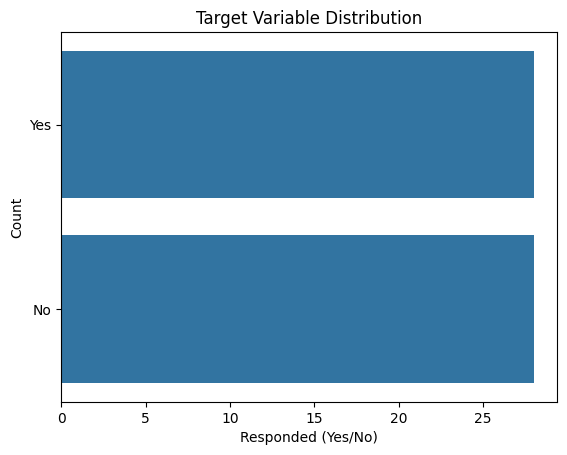

In [3]:
# Visualize target variable distribution
sns.countplot(data['responded'])
plt.title("Target Variable Distribution")
plt.xlabel("Responded (Yes/No)")
plt.ylabel("Count")
plt.show()

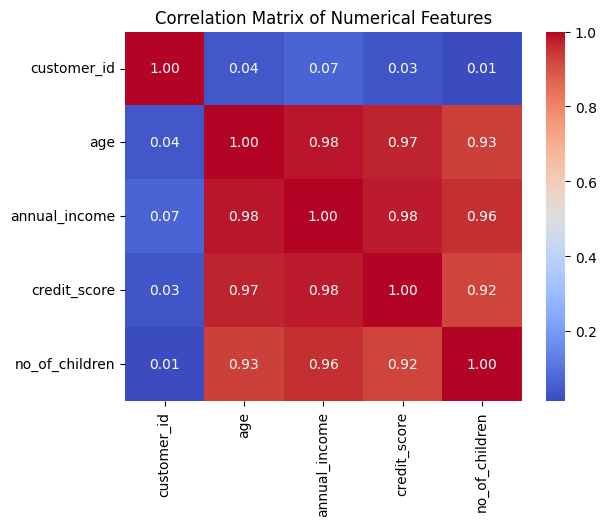

In [4]:
# Correlation heatmap for numerical features
corr = data.select_dtypes(include=['number']).corr() # Select only numerical columns for correlation
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

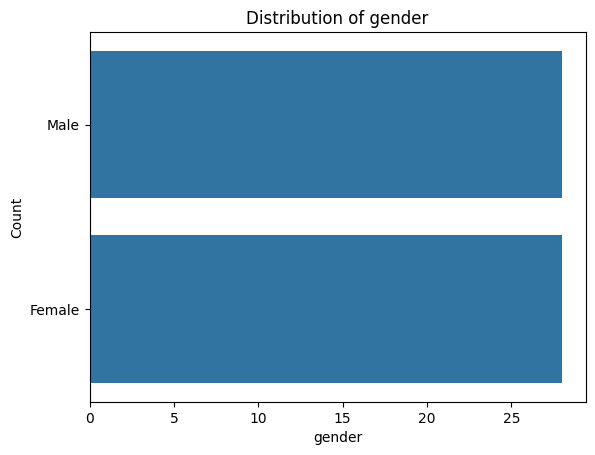

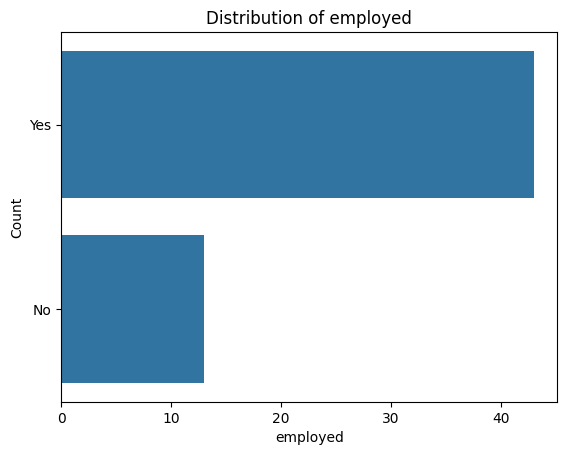

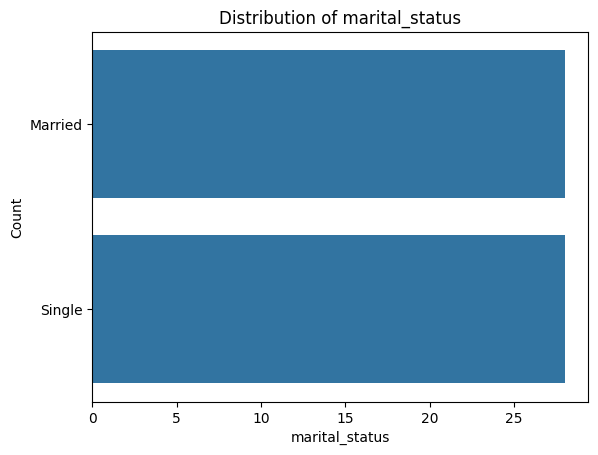

In [5]:
# Categorical feature distribution
for col in ['gender', 'employed', 'marital_status']:
    sns.countplot(data[col])
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


Logistic Regression
Cross-Validation Accuracy: 1.0000
Test Accuracy: 1.0000
              precision    recall  f1-score   support

          No       1.00      1.00      1.00         5
         Yes       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



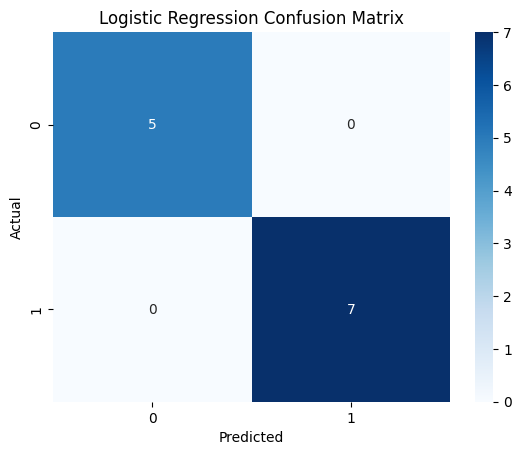


Random Forest
Cross-Validation Accuracy: 1.0000
Test Accuracy: 0.9167
              precision    recall  f1-score   support

          No       0.83      1.00      0.91         5
         Yes       1.00      0.86      0.92         7

    accuracy                           0.92        12
   macro avg       0.92      0.93      0.92        12
weighted avg       0.93      0.92      0.92        12



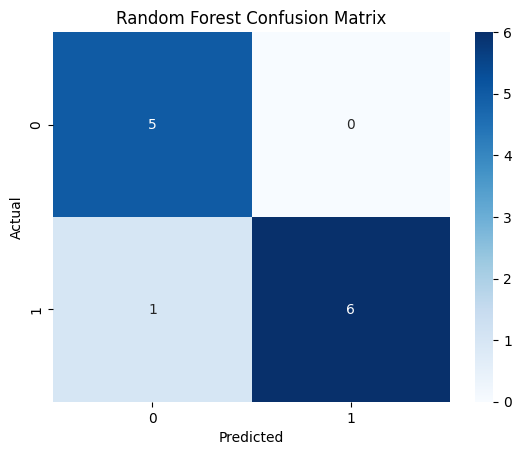


Gradient Boosting
Cross-Validation Accuracy: 1.0000
Test Accuracy: 1.0000
              precision    recall  f1-score   support

          No       1.00      1.00      1.00         5
         Yes       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



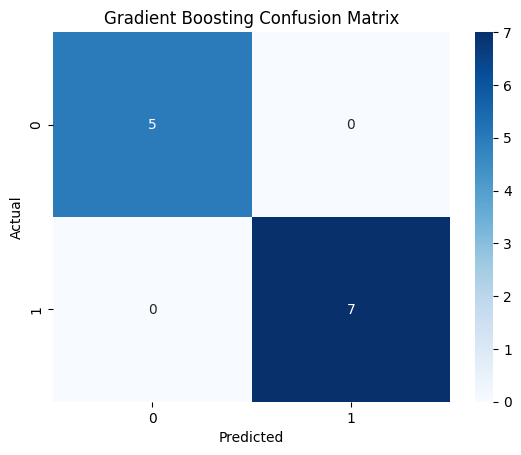

In [6]:
# Define features (X) and target (y)
X = data.drop(columns=['responded']) # Features
y = data['responded'] #Target
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'annual_income', 'credit_score', 'no_of_children']),
        ('cat', OneHotEncoder(drop='first'), ['gender', 'employed', 'marital_status'])
    ]
)
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Logistic Regression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
# Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
# Step 5: Evaluation function
def evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test) # Compute y_pred here
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return cv_scores.mean(), accuracy, report, y_pred # Return y_pred
# Evaluate each model
models = {
    'Logistic Regression': logreg_pipeline,
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline
}
results = {}
for name, pipeline in models.items():
    cv_acc, test_acc, report, y_pred = evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    results[name] = {
        'Cross-Validation Accuracy': cv_acc,
        'Test Accuracy': test_acc,
        'Classification Report': report
    }
    print(f"\n{name}")
    print(f"Cross-Validation Accuracy: {cv_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(report)
    # Plot Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

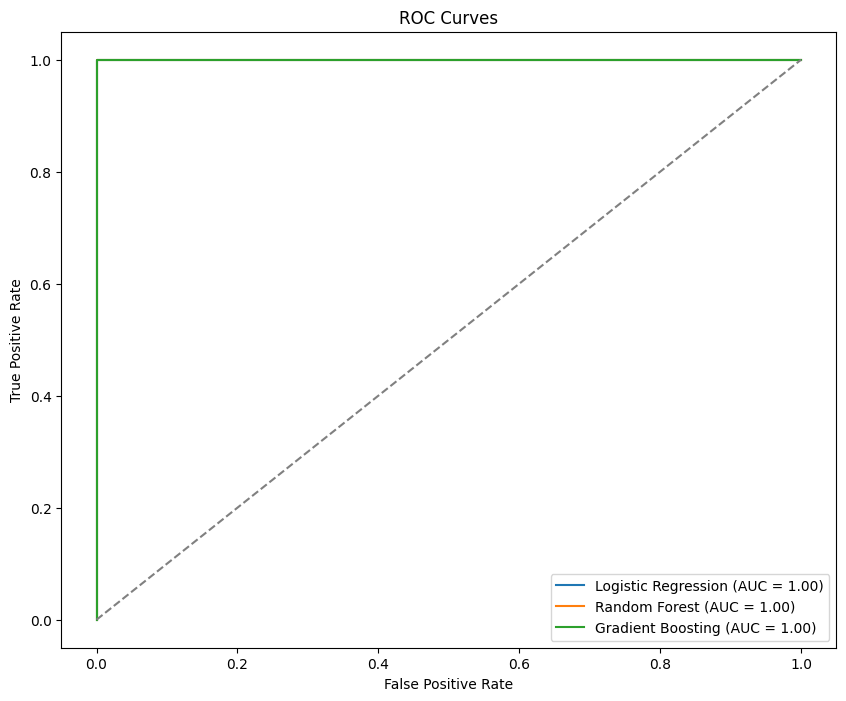

In [7]:
# Step 5: ROC Curve Visualization
def plot_roc_curve(model, X_test, y_test, label):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label='Yes')
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.figure(figsize=(10, 8))
for name, pipeline in models.items():
    plot_roc_curve(pipeline, X_test, y_test, name)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

/tmp/ipython-input-3273708801.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


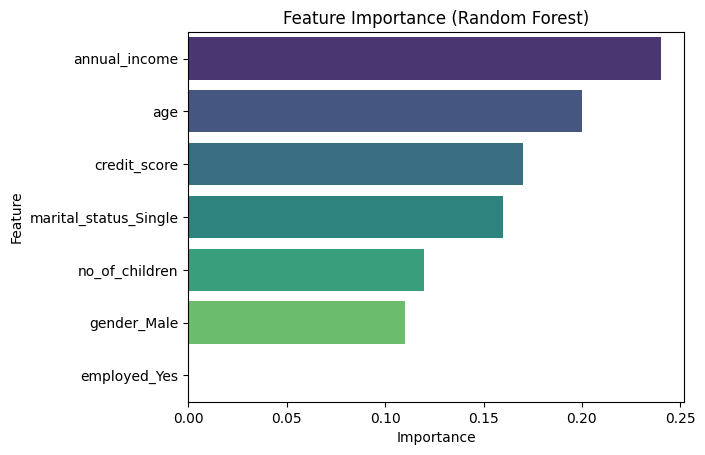

In [8]:
# Step 6: Feature Importance (Random Forest)
rf_pipeline.fit(X_train, y_train)
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_names = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][1].get_feature_names_out().tolist()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.show()

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Step 6: Hyperparameter Tuning for Random Forest (if it performs well)
rf_param_grid = {
'classifier__n_estimators': [50, 100, 150],
'classifier__max_depth': [10, 20, 30],
'classifier__min_samples_split': [2, 5, 10],
'classifier__min_samples_leaf': [1, 2, 4],
'classifier__bootstrap': [True, False]
}
rf_random_search = RandomizedSearchCV(
rf_pipeline, param_distributions=rf_param_grid, n_iter=20, cv=3, scoring='accuracy',
random_state=42, n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'annual_income',
                                                                                'credit_score',
                                                                                'no_of_children']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['gender',
                                                                                'employed',
                                                                                'marital_status'])])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [10, 20, 30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [50, 100,
                                                                     150]},
                   random_state=42, scoring='accuracy')

In [10]:
# Print the best parameters and results
print("\nBest Random Forest Parameters:", rf_random_search.best_params_)
y_pred_rf_tuned = rf_random_search.best_estimator_.predict(X_test)
print("Tuned Random Forest Classification Report:\n", classification_report(y_test,
y_pred_rf_tuned))


Best Random Forest Parameters: {'classifier__n_estimators': 150, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 30, 'classifier__bootstrap': False}
Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

          No       0.71      1.00      0.83         5
         Yes       1.00      0.71      0.83         7

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12

